<!-- Hasta ahora, hemos trabajado con diferencias de ángulo de rotación debido al desconocimiento del ángulo de rotación intrínseco (o inicial). Como consecuencia, estamos arrastrando errores sistemáticos en los datos y es necesario la realización de un pre-procesamiento.

Es decir, debemos comprobar si la siguiente consideración: $ \psi = \psi _0 + RM \lambda^2 $ es correcta.

Para ello, estudiamos la medida de rotación para diferencias del ángulo de rotación, estableciendo nuestro cero en 11 GHz. Para dar por válidos nuestros cálculos, recordemos que la RM es una constante y debe ser independiente de la frecuencia.

Una vez obtenida esta, estudiamos la significación (signal-to-noise ratio) para observar los píxeles significativos.

Lo que se busca es eliminar el ángulo de polarización intrínseco, por eso las diferencias. 
La radiación del sincrotrón que se percibe pertenece a toda la línea de visión (línea infinita), donde tenemos campos magnéticos tanto delante como atrás de esta. Es por ello que se produce una rotación adicional (ángulo intrínseco), creada por el hecho de ser una radiación polarizada linealmente. -->

En nuestras observaciones de emisión sincrotrón polarizada nos encontramos con un problema de base: el ángulo de polarización intrínseco, ψ₀, es desconocido y genera un desplazamiento constante que se arrastra a todas las frecuencias. Si ajustáramos directamente ψ(λ) frente a λ² sin corregir ese offset, obtendríamos valores de RM sesgados y aparentemente dependientes de la frecuencia, algo que carece de sentido físico y complica cualquier interpretación de los campos magnéticos en la línea de visión.

Para eliminar de raíz ese error sistemático, fijamos como referencia el ángulo medido a 11 GHz (λ≈2.7 cm). Al definir

$$
Δψ(λ) = ψ(λ) - ψ(11\ \mathrm{GHz}),
$$

nos aseguramos de que cualquier contribución constante de ψ₀ —incluyendo desplazamientos instrumentales o diferencias de calibración entre bandas— quede automáticamente cancelada. De este modo, la relación pasa a

$$
Δψ(λ) = \mathrm{RM}\,\bigl(λ^2 - λ_{\rm ref}^2\bigr),
$$

y al ajustar Δψ frente a (λ²–λ²\_ref) extraemos RM como la pendiente de forma limpia y libre de offsets.

Una vez generado el mapa inicial de RM, es fundamental comprobar su robustez. Calculamos la relación señal/ruido en cada píxel y descartamos aquellos que no superan el umbral que definamos (por ejemplo, S/N ≥ 3). Así evitamos que mediciones ruidosas reintroduzcan artefactos o falsas variaciones de RM. El resultado es un mapa de Medida de Rotación de Faraday fiable, que refleja únicamente la rotación acumulada a lo largo de toda la línea de visión y no se ve contaminado por el ángulo inicial ni por errores de calibración.

Este preprocesamiento, por tanto, es clave: primero identificamos y suprimimos el offset constante, luego medimos RM con independencia de la frecuencia, y finalmente filtramos por significación para garantizar la calidad de los datos. Con estos pasos claros en el código, podemos avanzar con la seguridad de que nuestra estimación de los campos magnéticos es sólida y físicamente coherente.


In [66]:
%matplotlib inline

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

##############################################################################
# BLOQUE 1: SENSIBILIDAD NORMALIZADA PARA Q
##############################################################################

def normsigQ(sig0, hitsQ):

    """Calcula la sensibilidad normalizada para Q"""
    
    sigQ = sig0 / np.sqrt(hitsQ)
    return sigQ

# Creamos un diccionario donde introducimos los valores de sensibilidad característica (sig0Q) para Q
sig0Q_values = {
    11: 1.371,                # 11 GHz => H3
    13: 1.188,                # 13 GHz => H3
    17: (1.878 + 1.101) / 2,  # 17 GHz => promedio H2, H4
    19: (2.280 + 1.059) / 2   # 19 GHz => promedio H2, H4
}

frecuencias = [11, 13, 17, 19]
sensQ_maps = {}  # Diccionario donde almacenaremos los mapas resultantes

for freq in frecuencias:
    archivo = f"quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits"
    
    # Leemos la sensibilidad característica para Q
    sig0Q = sig0Q_values[freq]
    
    # Cargamos el mapa de hits para Q, U
    hitsQU = hp.read_map(archivo, field=4)
    
    # Calculamos la sensibilidad normalizada llamando a la función definida previamente
    sigQ_norm = normsigQ(sig0Q, hitsQU)
    
    # Guardamos en el diccionario para cada iteracción (frecuencia)
    sensQ_maps[freq] = sigQ_norm

# # Definimos una función para graficar los mapas de sensibilidad normalizada
# def plot_map_Q(map_data, freq):
#     hp.mollview(
#         map_data, 
#         title=f'Sensibilidad Normalizada Q ( $\sigma_Q$ ) para {freq} GHz',
#         unit='$mK \, s^{1/2}$',
#         cmap='hsv'
#     )
#     hp.graticule()
#     plt.show()

# # Graficamos cada mapa de sensibilidad normalizada de Q
# for freq, map_data in sensQ_maps.items():
#     plot_map_Q(map_data, freq)

/tmp/ipykernel_1112/1008710251.py:15: RuntimeWarning: invalid value encountered in sqrt
  sigQ = sig0 / np.sqrt(hitsQ)


In [67]:
##############################################################################
# BLOQUE 2: SENSIBILIDAD NORMALIZADA PARA U
##############################################################################

def normsigU(sig0, hitsU):

    """Calcula la sensibilidad normalizada para U"""
    
    sigU = sig0 / np.sqrt(hitsU)
    return sigU

# Valores de sensibilidad característica (sig0U) para U
sig0U_values = {
    11: 1.372,                 # 11 GHz
    13: 1.188,                 # 13 GHz
    17: (1.875 + 1.100) / 2,   # 17 GHz => promedio H2, H4
    19: (2.273 + 1.064) / 2    # 19 GHz => promedio H2, H4
}

sensU_maps = {}  # Diccionario para los mapas de U

for freq in frecuencias:
    archivo = f"quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits"
    
    # Leemos la sensibilidad característica para U
    sig0U = sig0U_values[freq]
    
    # Cargamos el mismo mapa de hits para Q/U
    hitsQU = hp.read_map(archivo, field=4)
    
    # Calculamos la sensibilidad normalizada para U
    sigU_norm = normsigU(sig0U, hitsQU)
    
    # Guardamos el resultado en el diccionario
    sensU_maps[freq] = sigU_norm

# def plot_map_U(map_data, freq):
#     hp.mollview(
#         map_data, 
#         title=f'Sensibilidad Normalizada U ( $\sigma_U$ ) para {freq} GHz',
#         unit='$mK \, s^{1/2}$',
#         cmap='hsv'
#     )
#     hp.graticule()
#     plt.show()

# # Graficamos cada mapa de sensibilidad normalizada de U
# for freq, map_data in sensU_maps.items():
#     plot_map_U(map_data, freq)

/tmp/ipykernel_1112/108037883.py:9: RuntimeWarning: invalid value encountered in sqrt
  sigU = sig0 / np.sqrt(hitsU)


In [68]:
##############################################################################
# BLOQUE 3: PROPAGACIÓN DE ERROR DE LA FUNCIÓN DIFPSI
##############################################################################

# Función original para calcular psi
def difpsi(Q, U):
    psi = 0.5 * np.arctan2(U, Q) + np.pi/2
    return psi

# Función para calcular la incertidumbre en psi (propagación de errores)
def difpsi_error(Q, U, sigma_Q, sigma_U):
    
    """
        Calcula σ₍ψ₎ para cada píxel, a partir de Q, U, σ_Q y σ_U.
        Para ello, aplicamos propagción de errores a la función difpsi(Q, U). 
        Es decir, calculamos la derivada de ψ respecto a Q y U, y luego aplicamos la fórmula de propagación de errores, que es:
            
            σ₍ψ₎ = sqrt( (∂ψ/∂U)² * σ_U² + (∂ψ/∂Q)² * σ_Q² )

        siendo la derivada de la arcotangente: ∂/∂x [arctan (A)] = (∂A/∂x) / (1 + A²)

        Calculada cada derivada parcial, finalmente nos queda:

             σ₍ψ₎ = sqrt( (0.5*Q/(Q^2+U^2))² * σ_U² + (0.5*U/(Q^2+U^2))² * σ_Q² ).

    """
    denom = Q**2 + U**2
    # Para evitar división por cero, se pueden enmascarar los píxeles con denom cercano a 0.
    # Aquí usamos np.where para evitar problemas:

    """
        La función np.where es un condicional que nos facilita Numpy, tiene la siguiente estructura:
        np.where(condición, valor_si_verdadero, valor_si_falso)
        En este caso, si el denominador es diferente de cero, se calcula la derivada,
        de lo contrario se asigna 0 para evitar la división por cero.

    """

    dpsi_dU = 0.5 * np.where(denom!=0, Q/denom, 0)
    dpsi_dQ = 0.5 * np.where(denom!=0, -U/denom, 0)
    
    sigma_psi_sq = (dpsi_dU**2)*(sigma_U**2) + (dpsi_dQ**2)*(sigma_Q**2)
    sigma_psi = np.sqrt(sigma_psi_sq)
    return sigma_psi

# Bucle sobre las frecuencias para calcular y graficar ψ y su incertidumbre
for freq in frecuencias:
    archivo = f"quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits"
    
    # Lee mapas de Q y U
    mapQ = hp.read_map(archivo, field=1)
    mapU = hp.read_map(archivo, field=2)
    
    # Calcula psi
    psi = difpsi(mapQ, mapU)
    
    ########### --- ESTIMACIÓN DE LOS ERRORES EN Q y U --- ###########

    sigma_Q = sensQ_maps[freq]  # Sensibilidad normalizada para Q
    sigma_U = sensU_maps[freq]  # Sensibilidad normalizada para U
    
    # -----------------------------------------
    
    # Calcular la incertidumbre en psi
    sigma_psi = difpsi_error(mapQ, mapU, sigma_Q, sigma_U)
    
    # # Visualizar el mapa de la incertidumbre en psi
    # hp.mollview(sigma_psi,
    #             title=f"Incertidumbre en ángulo de polarización ( $\sigma_\psi$ ) a {freq} GHz",
    #             unit="rad",
    #             cmap="hsv",
    #             min=0,max=np.pi)
    # hp.graticule()
    # plt.show()

/tmp/ipykernel_1112/268550781.py:27: RuntimeWarning: overflow encountered in square
  denom = Q**2 + U**2


/tmp/ipykernel_1112/268550781.py:27: RuntimeWarning: overflow encountered in square
  denom = Q**2 + U**2


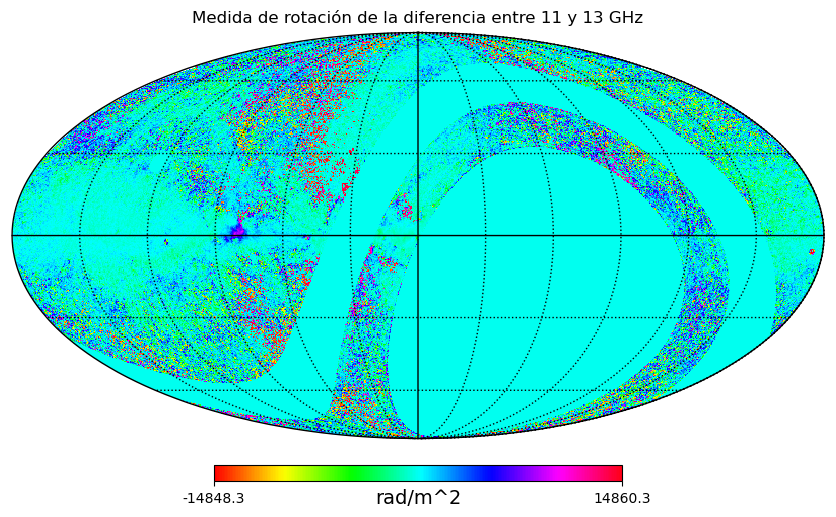

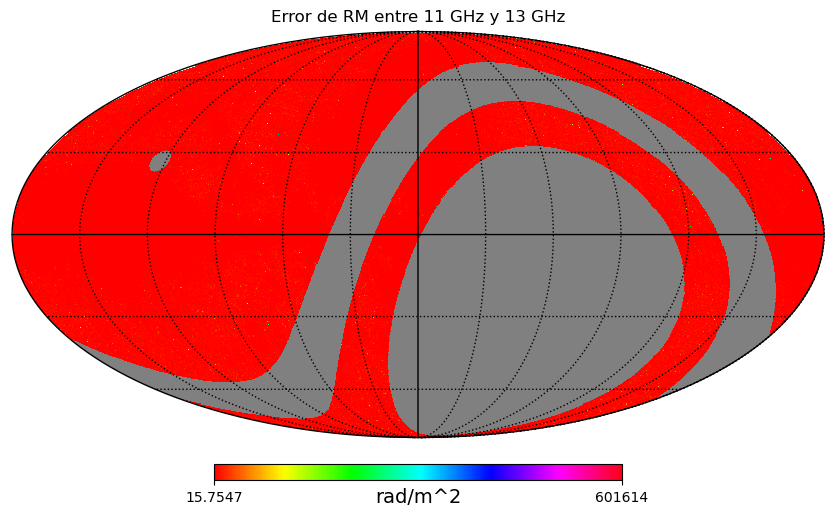

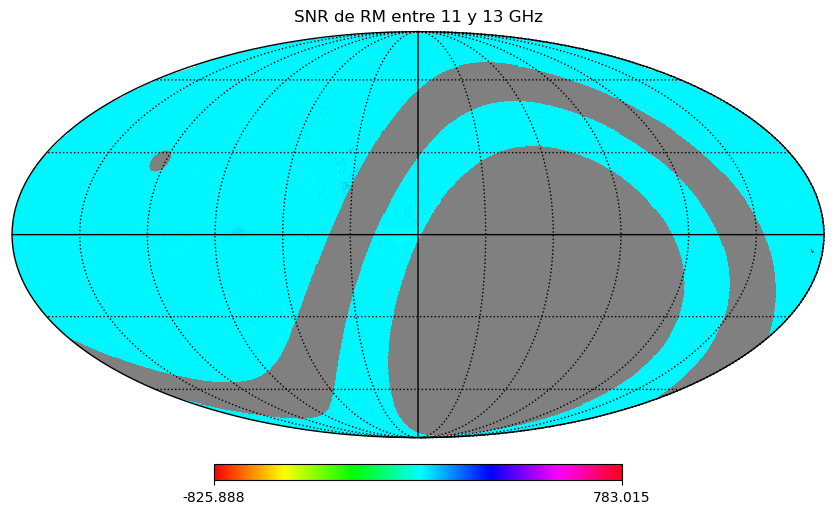

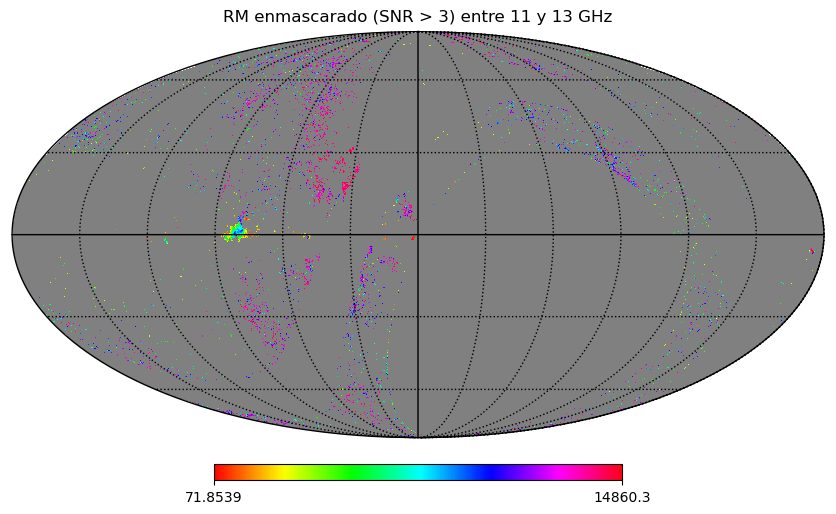

Píxeles observados por QUIJOTE a 13 GHz: 9319170
Píxeles con SNR > 3: 56882
Porcentaje sobre observados: 0.61%


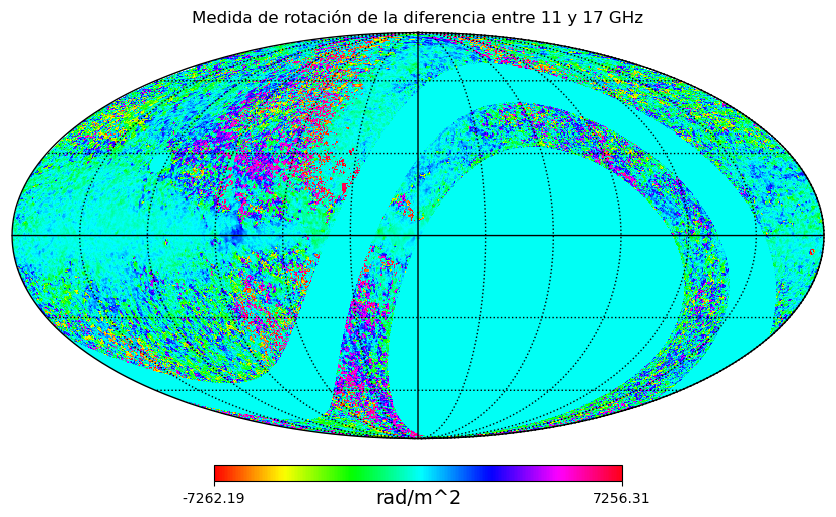

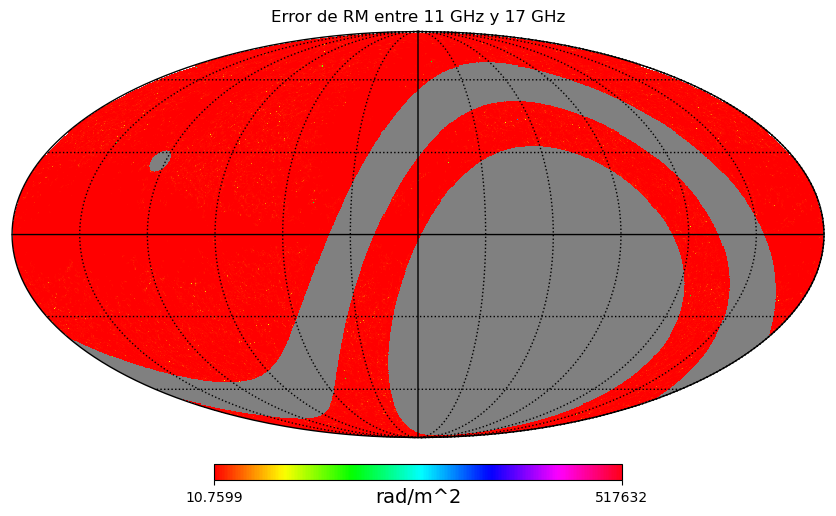

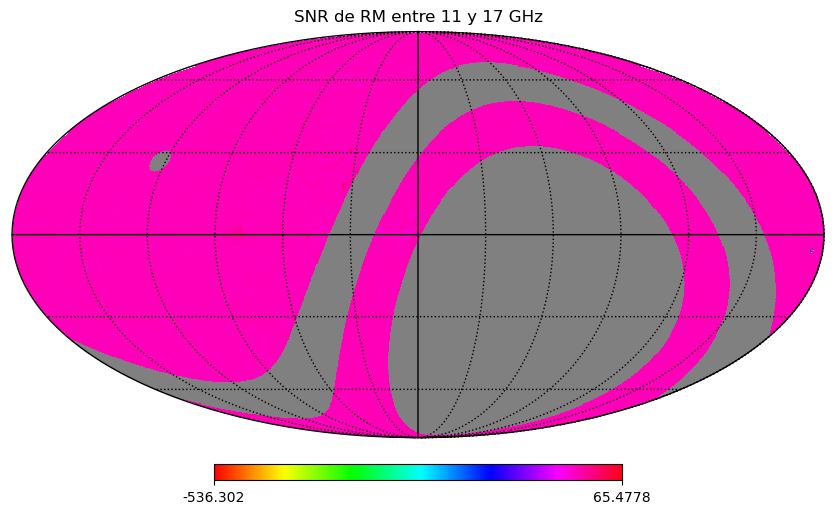

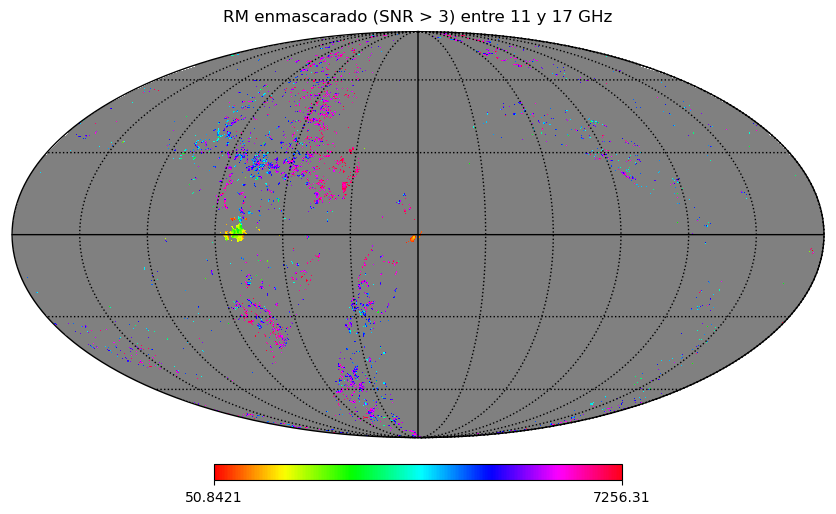

Píxeles observados por QUIJOTE a 17 GHz: 9320325
Píxeles con SNR > 3: 60994
Porcentaje sobre observados: 0.65%


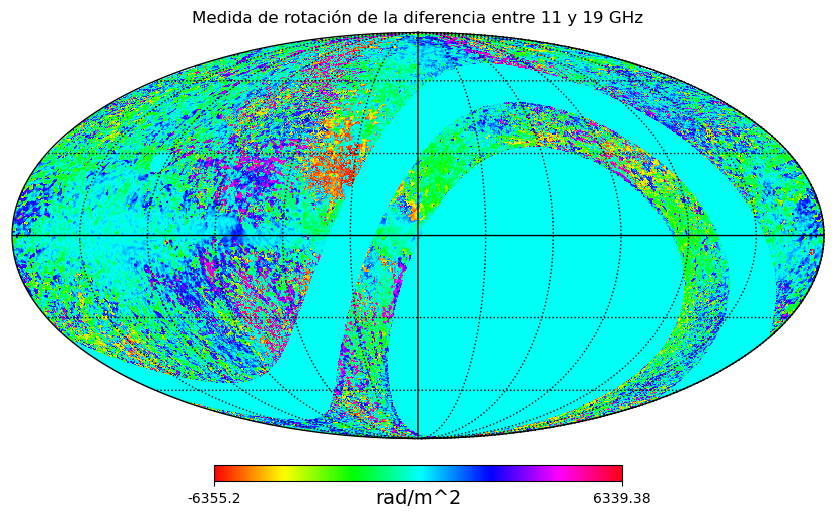

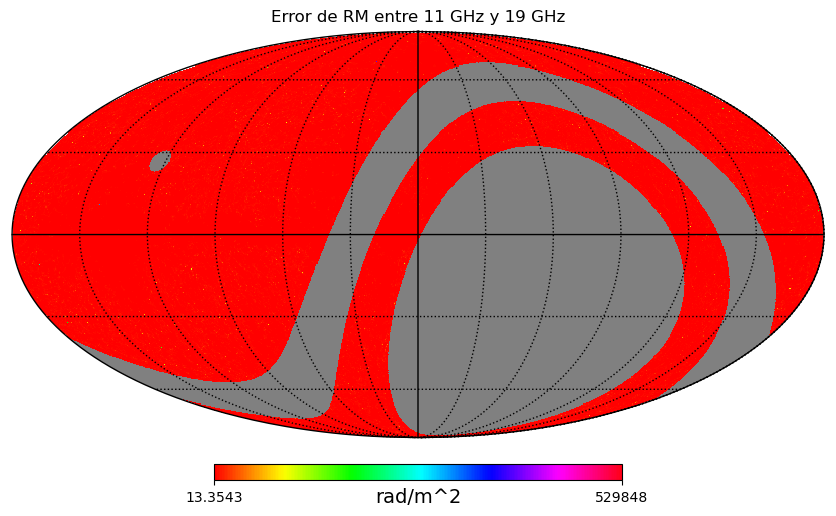

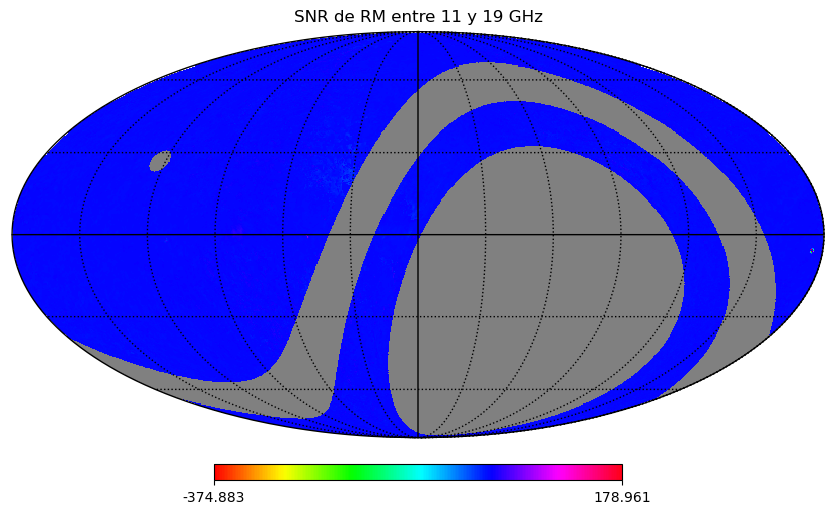

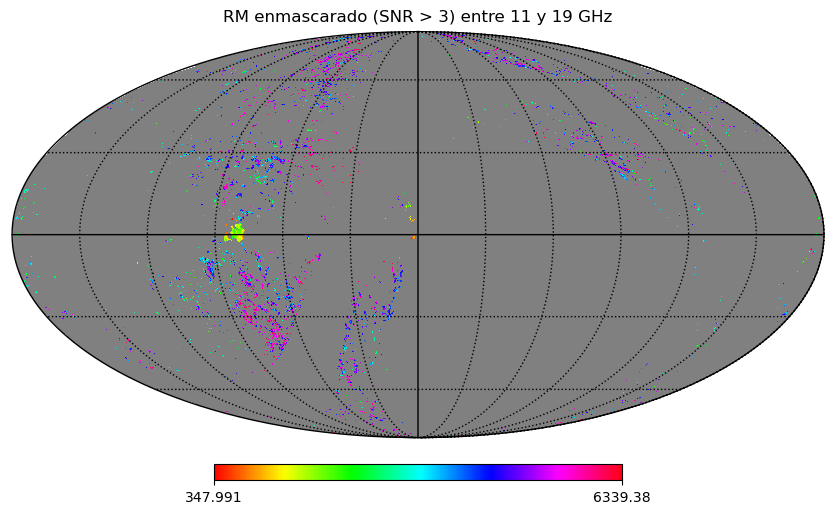

Píxeles observados por QUIJOTE a 19 GHz: 9320166
Píxeles con SNR > 3: 59551
Porcentaje sobre observados: 0.64%


In [69]:
##############################################################################
# BLOQUE 4: RM ENTRE 11 GHz Y OTRAS FRECUENCIAS
##############################################################################

# Tomamos como frecuencia de referencia 11 GHz
freq_ref = 11
lambda_ref = 299792458.0 / (freq_ref * 1e9)  

# Leo mapas de Q y U para 11 GHz
archivo_ref = f"quijote_mfi_smth_skymap_{freq_ref}ghz_512_dr1.fits"
mapQ_ref = hp.read_map(archivo_ref, field=1)
mapU_ref = hp.read_map(archivo_ref, field=2)
psi_ref = difpsi(mapQ_ref, mapU_ref)
sigma_Q_ref = sensQ_maps[freq_ref]
sigma_U_ref = sensU_maps[freq_ref]
sigma_psi_ref = difpsi_error(mapQ_ref, mapU_ref, sigma_Q_ref, sigma_U_ref)

for freq in [13, 17, 19]:
    lambda_freq = 299792458.0 / (freq * 1e9)  
    archivo = f"quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits"
    mapQ = hp.read_map(archivo, field=1)
    mapU = hp.read_map(archivo, field=2)
    psi = difpsi(mapQ, mapU)
    sigma_Q = sensQ_maps[freq]
    sigma_U = sensU_maps[freq]
    sigma_psi = difpsi_error(mapQ, mapU, sigma_Q, sigma_U)

    delta_psi = psi_ref - psi
    delta_lambda2 = lambda_ref**2 - lambda_freq**2

    RM = delta_psi / delta_lambda2
    sigma_RM = np.sqrt(sigma_psi_ref**2 + sigma_psi**2) / np.abs(delta_lambda2)

    # Visualiza el mapa de RM y su error
    hp.mollview(RM,
                title=f"Medida de rotación de la diferencia entre 11 y {freq} GHz",
                unit="rad/m^2",
                cmap="hsv")
    hp.graticule()
    plt.show()

    hp.mollview(sigma_RM,
                title=f"Error de RM entre 11 GHz y {freq} GHz",
                unit="rad/m^2",
                cmap="hsv")
                #min=0, max=12800)
    hp.graticule()
    plt.show()

    ##############################################################################
    # BLOQUE 5: OBTENCIÓN DEL SNR (SIGNAL TO NOISE RATIO)
    ##############################################################################

    SNR_RM = np.full_like(RM, hp.UNSEEN)
    mask = sigma_RM > 0
    SNR_RM[mask] = RM[mask] / sigma_RM[mask]

    hp.mollview(SNR_RM,
                title=f"SNR de RM entre 11 y {freq} GHz",
                cmap="hsv")
                #min=0, max=100)
    hp.graticule()
    plt.show()

    # Enmascaramos RM donde SNR < 3
    umbral_snr = 3
    RM_masked = np.where(SNR_RM > umbral_snr, RM, hp.UNSEEN)
    hp.mollview(RM_masked,
                title=f"RM enmascarado (SNR > {umbral_snr}) entre 11 y {freq} GHz",
                cmap="hsv")
    hp.graticule()
    plt.show()

    # Para saber el número de píxeles totales observados por QUIJOTE, 
    # leemos el mapa original con todas sus columnas: 
    mapa=hp.read_map(archivo, field=(0,1,2,3,4)) 
    # Para asegurarnos que sean los píxeles OBSERVADOS, aplicamos la condición de que no sean UNSEEN:
    n_observados = np.sum(mapa != hp.UNSEEN)
    # Número de píxeles observados que cumplen el umbral de SNR
    n_umbral = np.sum(RM_masked != hp.UNSEEN)
    # Porcentaje
    porcentaje = 100 * n_umbral / n_observados if n_observados > 0 else 0

    print(f"Píxeles observados por QUIJOTE a {freq} GHz: {n_observados}")
    print(f"Píxeles con SNR > {umbral_snr}: {n_umbral}")
    print(f"Porcentaje sobre observados: {porcentaje:.2f}%")
    

Los píxeles que saturan las gráficas pertenecen al Crab pulsar.